In [9]:
import sys
 
sys.path.insert(0, "../")

In [10]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import add_self_loops

citeseer_dataset = Planetoid(root = "../data", name = "CiteSeer")
cora_dataset = Planetoid(root = "../data", name = "Cora")
pubmed_dataset = Planetoid(root = "../data", name = "PubMed")

def pre_process(dataset):
    dataset.transform = T.NormalizeFeatures()
    return dataset

def add_set(set_name):
    global name_to_sets, name_to_dataset
    name_to_sets[set_name] = dict({})
    
    dataset = name_to_dataset[set_name]
    X =  dataset[0].x 
    y =  dataset[0].y 
    
    test =  dataset[0].test_mask
    train = dataset[0].train_mask 
    val =  dataset[0].val_mask
    
    edge_index = add_self_loops(dataset[0].edge_index)[0]

    name_to_sets[set_name]["X"] = X
    name_to_sets[set_name]["y"] = y
    name_to_sets[set_name]["test"] = test
    name_to_sets[set_name]["train"] = train
    name_to_sets[set_name]["val"] = val
    name_to_sets[set_name]["edge_index"] = edge_index

def create_sets():
    for set_name in name_to_dataset.keys():
        add_set(set_name)


CORA = "Cora"
PUBMED = "PubMed"
CITESEER = "Citeseer"

name_to_dataset = dict({})
name_to_dataset[CORA] = pre_process(cora_dataset)
name_to_dataset[PUBMED] = pre_process(pubmed_dataset)
name_to_dataset[CITESEER] = pre_process(citeseer_dataset)
name_to_sets = dict({})
create_sets()
name_to_sets

{'Cora': {'X': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]),
  'y': tensor([3, 4, 4,  ..., 3, 3, 3]),
  'test': tensor([False, False, False,  ...,  True,  True,  True]),
  'train': tensor([ True,  True,  True,  ..., False, False, False]),
  'val': tensor([False, False, False,  ..., False, False, False]),
  'edge_index': tensor([[   0,    0,    0,  ..., 2705, 2706, 2707],
          [ 633, 1862, 2582,  ..., 2705, 2706, 2707]])},
 'PubMed': {'X': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0554, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0114, 0.0047,  ..., 0.0000, 0.0000, 0.0000],
          [0.0531, 0.0000, 0.0000,  ..., 0.0000, 0.000

In [11]:
from AutoTune2 import upd_user_function, norm_user_function
from sklearn.linear_model import LogisticRegression
store = {'LogisticRegression': {0: {'train_acc': 0.9833333333333333,
   'val_acc': 0.742,
   'test_acc': 0.737,
   'model': LogisticRegression(C=19.012946053218332, max_iter=4096,
                      tol=0.011693958862167635),
   'user_function': upd_user_function,
   'attention_config': {'inter_layer_normalize': True,
    'use_pseudo_attention': True,
    'cosine_eps': 0.001,
    'dropout_attn': None}},
  3: {'train_acc': 0.9833333333333333,
   'val_acc': 0.812,
   'test_acc': 0.802,
   'model': LogisticRegression(C=2.3417904147486635, max_iter=4096,
                      tol=1.877242326314165e-05),
   'user_function': norm_user_function,
   'attention_config': {'inter_layer_normalize': False,
    'use_pseudo_attention': True,
    'cosine_eps': 0.01,
    'dropout_attn': None}},
  8: {'train_acc': 0.9666666666666667,
   'val_acc': 0.826,
   'test_acc': 0.793,
   'model': LogisticRegression(C=8.816857543671555, max_iter=256, tol=0.0003864950814262107),
   'user_function': norm_user_function,
   'attention_config': None}}}

In [12]:
from EnsembleFramework import Framework
import time

def fit_dataset(set_name,user_functions=[], hops_list = [], clfs = [], attention_configs= []):
    name_to_model = dict({})
    dataset = name_to_sets[set_name]
    y = dataset["y"]
    
    start = time.time()
    framework = Framework(user_functions, 
                     hops_list=hops_list, ## to obtain best for local neighborhood
                     clfs=clfs,
                     gpu_idx=0,
                     handle_nan=0.0,
                    attention_configs=attention_configs)
    vals = framework.get_features(dataset["X"], dataset["edge_index"], dataset["val"])
    vals = [val.cpu() for val in vals]
    kwargs_list=[{"eval_set":[(vals[i], y[dataset["val"]])], "early_stopping_rounds":5} if clf.__class__.__name__ == 'XGBClassifier' else {} for i, clf in enumerate(clfs)]
    framework.fit(dataset["X"], dataset["edge_index"], y, dataset["train"], kwargs_list)
    end = time.time()-start
    name_to_model[set_name] = framework
    return framework, end

In [13]:
from sklearn.metrics import accuracy_score

def predict_dataset(set_name,framework):
    dataset = name_to_sets[set_name]
    
    y = dataset["y"]
    framework = name_to_model[set_name]
    pred = framework.predict(dataset["X"], dataset["edge_index"], dataset["test"]) 
    pred_val = framework.predict(dataset["X"], dataset["edge_index"], dataset["val"]) 
    y_test = y[dataset["test"]]
    y_val = y[dataset["val"]]
    return {
        "test_acc": accuracy_score(y_test, pred),
        "val_acc": accuracy_score(y_val, pred_val)
    }

In [14]:
user_functions = [ store["LogisticRegression"][0]["user_function"],store["LogisticRegression"][3]["user_function"], store["LogisticRegression"][8]["user_function"]]
clfs = [store["LogisticRegression"][0]["model"],store["LogisticRegression"][3]["model"], store["LogisticRegression"][8]["model"]]
attention_configs = [store["LogisticRegression"][0]["attention_config"], store["LogisticRegression"][3]["attention_config"], store["LogisticRegression"][8]["attention_config"]]

framework, _ = fit_dataset(PUBMED, user_functions=user_functions, hops_list= [0, 3, 8], clfs = clfs, attention_configs= attention_configs)
predict_dataset(PUBMED, framework)

NameError: name 'name_to_model' is not defined

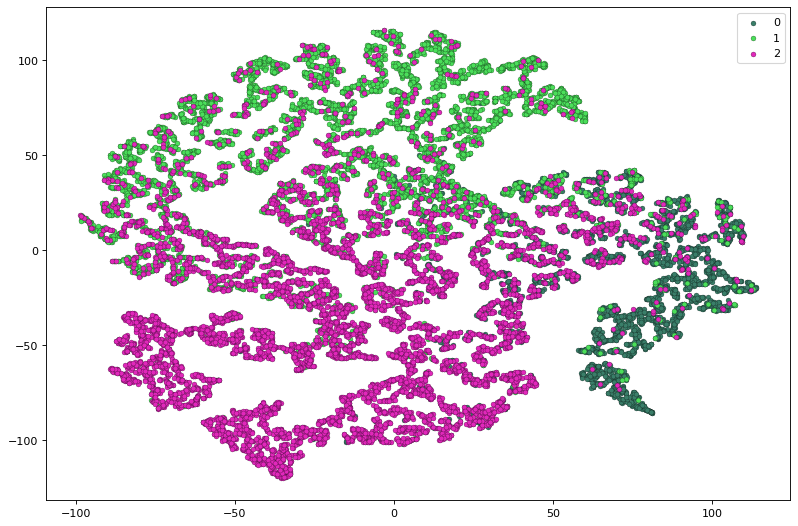

In [12]:
import torch
dataset = name_to_sets[PUBMED]
framework.plot_tsne(dataset["X"], dataset["edge_index"],dataset["y"],torch.ones(dataset["X"].shape[0]).type(torch.bool))

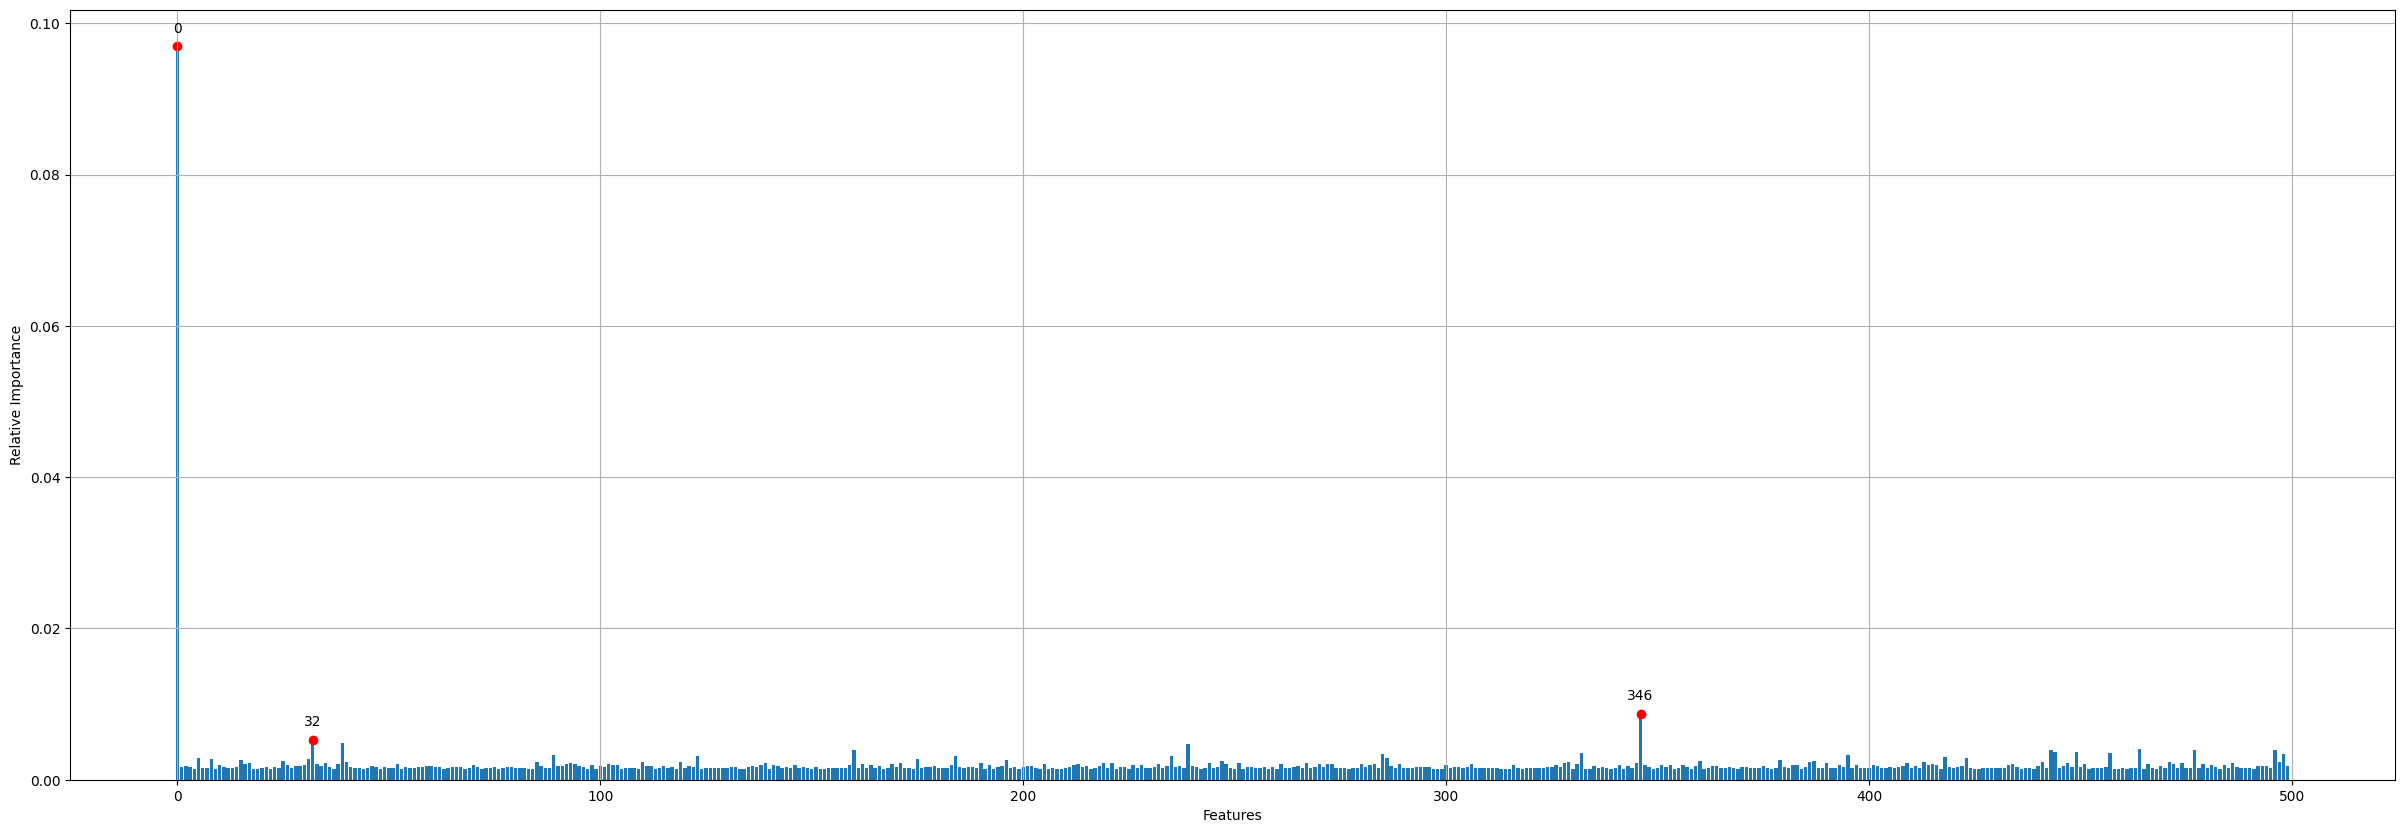

In [13]:
import matplotlib.pyplot as plt
dataset = name_to_sets[PUBMED]
framework.set_dataset(dataset)
fig, ax = plt.subplots()
fig.set_figwidth(30) 
fig.set_figheight(10) 
framework.plot_feature_importances(mark_top_n_peaks = 3)